In [4]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as apu

from galpy.potential import turn_physical_off,IsothermalDiskPotential,HernquistPotential,NumericalPotentialDerivativesMixin,verticalfreq
from galpy.potential import evaluateSurfaceDensities, evaluateDensities, evaluatezforces

from galpy.util.bovy_conversion import dens_in_msolpc3, get_physical, mass_in_msol, time_in_Gyr, surfdens_in_msolpc2, freq_in_kmskpc,force_in_2piGmsolpc2
from galpy.util import bovy_plot
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=16.,xtick_labelsize=14.,ytick_labelsize=14.)
import galpy
from galpy.potential.mwpotentials import McMillan17, Irrgang13I, MWPotential2014
from galpy.potential import verticalfreq,turn_physical_off,toVerticalPotential

from scipy.integrate import simps

from py import DiscClass
import importlib
importlib.reload(DiscClass)
importlib.reload(galpy)

from galpy.util import bovy_plot
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=16.,xtick_labelsize=14.,ytick_labelsize=14.)

FilePath= '/epsen_data/scr/bennett/Sgr-VerticalWaves/'

# Start by looking at more realistic potentials

Load the Sagittarius orbit which goes back through 2 pericentres and ends today. 

In [7]:
with open(FilePath+'data/Orbits/ModelOrbits/MW1_SGR1_2apo2now',"rb") as f:
    sgr2apo = pickle.load(f)
    
with open(FilePath+'data/SgrModel/halo_masses.dat','rb') as f:
    halo_m= np.loadtxt(f)
with open(FilePath+'data/SgrModel/halo_radius.dat','rb') as f:
    halo_a= np.loadtxt(f)
with open(FilePath+'data/SgrModel/stlr_masses.dat','rb') as f:
    stlr_m= np.loadtxt(f)
with open(FilePath+'data/SgrModel/stlr_radius.dat','rb') as f:
    stlr_a= np.loadtxt(f)
with open(FilePath+'data/SgrModel/sgr_rhm.dat','rb') as f:
    sgr_rhm= np.loadtxt(f)
    
A_data= np.loadtxt('data/Gaia/A_data.txt')
vz_data= np.loadtxt(FilePath+'data/Gaia/vel_data.txt')

## Choose the three realistic Milky Way Potentials from galpy 

Use those potentials to set the units for distance, velocity, time, mass, and surface density.

In [9]:
bp= galpy.potential.PowerSphericalPotentialwCutoff(alpha=1.8,rc=1.9/8.,normalize=0.05,ro=8.178*apu.kpc)
dp= galpy.potential.MiyamotoNagaiPotential(a=3./8.,b=0.28/8.,normalize=.6,ro=8.178*apu.kpc)
hp= galpy.potential.NFWPotential(a=16/8.,normalize=.35,ro=8.178*apu.kpc)

totpot= [[bp,dp,hp],[bp,dp,hp*1.5],[bp,dp,hp*2.],McMillan17,Irrgang13I]
[turn_physical_off(p) for p in totpot]

mwp= [toVerticalPotential(p,1.) for p in totpot]

MLU= np.array([get_physical(pot)['ro'] for pot in mwp])
MVU= np.array([get_physical(pot)['vo'] for pot in mwp])
MTU= np.array([time_in_Gyr(MVU[i],MLU[i])*1000. for i in range(5)])
MMU= np.array([mass_in_msol(MVU[i],MLU[i]) for i in range(5)])
MSDU= MMU/(MLU*1000.)**2

print('MWP14-1 vertical frequency',verticalfreq(MWPotential2014,1.)*freq_in_kmskpc(MVU[0],MLU[0]))
print('MWP14-2 vertical frequency',verticalfreq([bp,dp,hp*1.5],1.)*freq_in_kmskpc(MVU[1],MLU[1]))
print('MWP14-3 vertical frequency',verticalfreq([bp,dp,hp*2.],1.)*freq_in_kmskpc(MVU[2],MLU[2]))
print('McMillan17 vertical frequency',verticalfreq(McMillan17,1.)*freq_in_kmskpc(MVU[3],MLU[3]))
print('Irrgang13I vertical frequency',verticalfreq(Irrgang13I,1.)*freq_in_kmskpc(MVU[4],MLU[4]))
print()
print('MWP14-1 mid-plane density',evaluateDensities(MWPotential2014,R=1.,z=0.)*dens_in_msolpc3(MVU[0],MLU[0]))
print('MWP14-2 mid-plane density',evaluateDensities([bp,dp,hp*1.5],1.,z=0.)*dens_in_msolpc3(MVU[1],MLU[1]))
print('MWP14-3 mid-plane density',evaluateDensities([bp,dp,hp*2.],1.,z=0.)*dens_in_msolpc3(MVU[2],MLU[2]))
print('McMillan17 mid-plane density',evaluateDensities(McMillan17,1.,z=0.)*dens_in_msolpc3(MVU[3],MLU[3]))
print('Irrgang13I mid-plane density',evaluateDensities(Irrgang13I,1.,z=0.)*dens_in_msolpc3(MVU[4],MLU[4]))

MWP14-1 vertical frequency 73.32097415076268
MWP14-2 vertical frequency 74.17958334773103
MWP14-3 vertical frequency 75.02836744104953
McMillan17 vertical frequency 78.61376140888635
Irrgang13I vertical frequency 74.77362318020036

MWP14-1 mid-plane density 0.09676602007657945
MWP14-2 mid-plane density 0.10037553729333011
MWP14-3 mid-plane density 0.10398505451008078
McMillan17 mid-plane density 0.11432017189412096
Irrgang13I mid-plane density 0.10195819627107698


### Initialize three discs where disc orbits are integrated in each realistic potential

In [10]:
Zpts=100
Vpts=50
discs= np.empty(5,dtype='object')
timePU= sgr2apo.time()*time_in_Gyr(sgr2apo._vo,sgr2apo._ro)*1000.

for i,pp in enumerate(mwp):
    discs[i]= DiscClass.StellarDisc([pp],zlim=2.,vlim=120.,times=timePU/MTU[i],zpt=Zpts,vpt=Vpts)

/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)



### Calculate the three component isothermal disc distribution function components for each potential

Use the surface density of three isothermal disc components taken from JO'S PAPER! The sum of the three surface densities is scaled such that they add to the surface density of the galpy potential.
$$A_i= \Sigma_i \frac{1}{\int \int f_i(z,v)\,dv\,dz}$$ 
This is then used to calculate the mid-plane density:
$$\rho_{0,i}= \left.2A_i\int f_i(z,v)\,dv \right|_{z=0}$$

In [11]:
dens= (np.tile(np.array([21,5.8,2.44]),(5,1)).T/MSDU).T
sig= (np.tile(np.array([23.2,36.6,46.0]),(5,1)).T/MVU).T

Area= np.empty([5,3])
rho= np.empty([5,3])

for j in range(5):#for j in range(5):
    for i in range(3):
        Area[j,i]= dens[j,i]*evaluateSurfaceDensities(totpot[j],1.,1.)/np.sum(dens[j])/simps(simps(np.exp(-discs[j].Jz*discs[j].Oz/(sig[j,i])**2),discs[j].v,axis=1),discs[j].z)
        rho[j,i]= np.max(2*Area[j,i]*simps(np.exp(-discs[j].Jz*discs[j].Oz/(sig[j,i])**2),discs[j].v,axis=1))
        
print(rho)

[[1.10056262 0.17100939 0.05808576]
 [1.51141367 0.23488565 0.07924337]
 [1.94430078 0.30248734 0.10144733]
 [1.32817873 0.20724264 0.07006089]
 [1.25792871 0.19476295 0.06559984]]


### Initialize the Sgr potentials with distance and velocity units set by the potential and then add them to the discs with the three component distribution function calculated above

In [12]:
sgr_pot= np.empty([5,5],dtype='object')

for j in range(5):
    for i in range(5):
        halo_pot= galpy.potential.HernquistPotential(amp=2.*halo_m[j]*apu.M_sun,a=halo_a[j]*apu.kpc,ro=MLU[i],vo=MVU[i]) 
        stlr_pot= galpy.potential.HernquistPotential(amp=2.*stlr_m[j]*apu.M_sun,a=stlr_a[j]*apu.kpc,ro=MLU[i],vo=MVU[i]) 

        sgr_pot[i,j]= halo_pot+stlr_pot
        turn_physical_off(sgr_pot[i,j])

In [13]:
rotfreq=1.
labels=['MWP14-1','MWP14-2','MWP14-3','McMillan17','Irrgang13I']
linestyle= ['-','-.',':','--',(0, (3, 1, 1, 1, 1, 1))]
Force= np.zeros([5,100,50,2001])

def SgrForce(x,t):
    SgrTU= time_in_Gyr(sgr2apo._vo,sgr2apo._ro)*1000.
    dx= (rotfreq*np.cos(t/SgrTU)-sgr2apo.x(t/SgrTU))*sgr2apo._ro
    dy= (rotfreq*np.sin(t/SgrTU)-sgr2apo.y(t/SgrTU))*sgr2apo._ro
    dz= x-sgr2apo.z(t/SgrTU)*sgr2apo._ro    
    dR= np.sqrt(dx**2.+dy**2.)

    F= evaluatezforces(sgr_pot[0,1],R=dR/sgr2apo._ro,z=dz/sgr2apo._ro,
                       use_physical=False)*force_in_2piGmsolpc2(sgr2apo._vo,sgr2apo._ro)
    return F


for i in range(5):
    sgr2apo.turn_physical_off()
    tt= sgr2apo.time()*time_in_Gyr(sgr2apo._vo,sgr2apo._ro)*1000.
    xx= discs[i].discOrb.x(tt/MTU[i])*MLU[i]

    Force[i]= SgrForce(xx,tt)

In [14]:
for i in range(5):
    discs[i].add_force(Force[i]/force_in_2piGmsolpc2(MVU[i],MLU[i]),tt/MTU[i],[rho[i],sig[i]],zsun='fit',tdep=False,method='slow')

/home/bennett/.local/lib/python3.6/site-packages/galpy/potential/SCFPotential.py:288: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  func[j] = numpy.sum(self._compute(funcTilde, R[j][0],z[j][0],phi[j][0]))



### Plot asymmetry and mean vertical velocity for the three realistic potentials

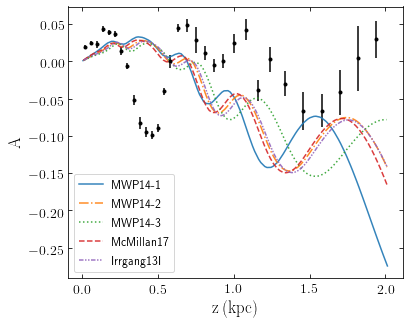

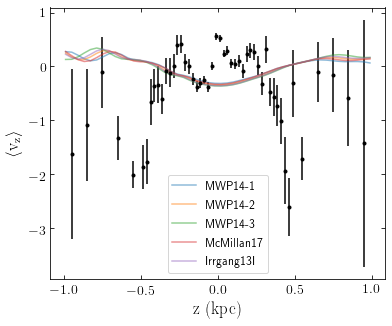

In [17]:
labels=['MWP14-1','MWP14-2','MWP14-3','McMillan17','Irrgang13I']
linestyle= ['-','-.',':','--',(0, (3, 1, 1, 1, 1, 1))]

plt.figure(figsize=(6,5))
for i in range(5):
    plt.plot(discs[i].zA*MLU[i],discs[i].A,label=labels[i],alpha=0.9,ls=linestyle[i])
plt.errorbar(A_data[0],A_data[1],A_data[2],ls='',fmt='.',c='k')

plt.xlabel(r'$\mathrm{z\,(kpc)}$')
plt.ylabel(r'$\mathrm{A}$')
plt.legend(loc=3)
plt.savefig(FilePath+'plots/realA.pdf',bbox_inches='tight')


plt.figure(figsize=(6,5))
for i in range(5):
    plt.plot(discs[i].z[np.abs(discs[i].z*MLU[i])<1.]*MLU[i],
             discs[i].meanV[np.abs(discs[i].z*MLU[i])<1.]*MVU[i]-np.mean(discs[i].meanV[np.abs(discs[i].z*MLU[i])<1.]*MVU[i]),
             label=labels[i],alpha=0.5)
plt.errorbar(vz_data[0],vz_data[1],yerr=vz_data[2],color='k',ls='',fmt='.')

plt.xlabel(r'$\mathrm{z\,\,(kpc)}$')
plt.ylabel(r'$\mathrm{\langle v_{z}\rangle}$')
plt.legend(loc=8)

# Calculate asymmetry for a wide array of Sgr Orbits
### Import the 10010 satellite orbits for a given Sgr and MW

Use these to calculate the units.  
Also, McMillan17 and Irrgang13I can't be pickled, so they need to be added back to the orbit.

In [19]:
o= np.empty([5,5],dtype=object)

for i in range(5):
    for j in range(5):
        fname= FilePath+"data/Orbits/dynfric/osgr_halo"+str(i)+"_sgr"+str(j)+".pickle"
        with open(fname,"rb") as f:
            o[i,j] = pickle.load(f)
            o[i,j].turn_physical_off()

sgr_masses= halo_m+stlr_m

for j in range(2):
    for i in range(5):
        chand_dynfric = galpy.potential.ChandrasekharDynamicalFrictionForce(amp=1.,
                                                                            GMs=sgr_masses[i]*apu.M_sun, 
                                                                            rhm=sgr_rhm[i]*apu.kpc,
                                                                            dens=totpot[j+3],
                                                                            ro=MLU[j+3], vo=MVU[j+3])
        o[j+3,i]._pot= totpot[j+3]+chand_dynfric
        o[j+3,i].turn_physical_off()

/home/bennett/.local/lib/python3.6/site-packages/galpy/potential/DiskSCFPotential.py:265: RuntimeWarning: overflow encountered in cosh
  th= lambda z, tzd=zd: 1./numpy.cosh(z/2./tzd)**2./4./tzd

/home/bennett/.local/lib/python3.6/site-packages/galpy/potential/DiskSCFPotential.py:265: RuntimeWarning: overflow encountered in double_scalars
  th= lambda z, tzd=zd: 1./numpy.cosh(z/2./tzd)**2./4./tzd



### Use the initial conditions from the above simulation to calculate the orbits for McMillan17 and Irrgang13I potentials aswell

In [20]:
with open(FilePath+'data/Orbits/vz_through.dat','rb') as f:
    vz_through= np.load(f)[:,:5]
with open(FilePath+'data/Orbits/t_through.dat','rb') as f:
    t_through= np.load(f)[:,:5]

Bin the orbits along $v_{z,through}$ into ten bins, find the median orbit and plot for each case.

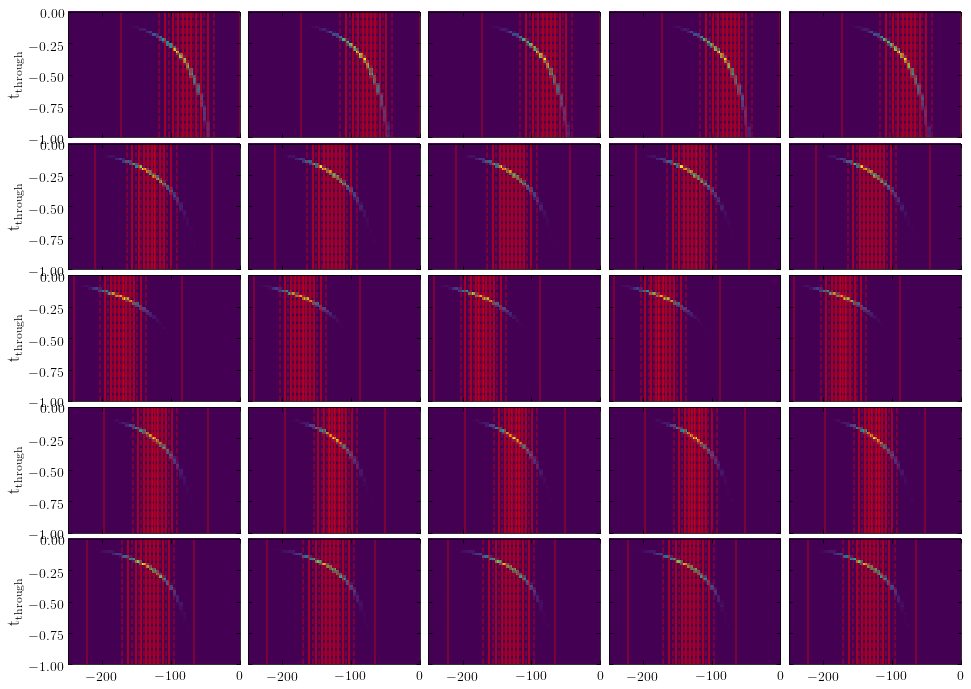

In [22]:
nbins= 10
n_samp= 10010
medianindx= np.zeros([5,5,nbins],dtype='int')

fig, ax= plt.subplots(5,5,figsize=(16,12),sharex=True,sharey=True)
for j in range(5):
    for k in range(5):
        sindx= np.argsort(vz_through[j,k])
        edges= np.array([(int(i)*1001,int(i*(1001)+1000)) for i in range(nbins)])
        median= np.array([i*1001+500 for i in range(nbins)])

        edgesindx= sindx[edges]
        medianindx[j,k]= sindx[median]
        vzmean= vz_through[j,k,medianindx[j,k]]
        vzedge1= vz_through[j,k,edgesindx[:,0]]
        vzedge2= vz_through[j,k,edgesindx[:,1]]
        ax[j,0].set_ylabel(r'$\mathrm{t_{through}}$')
        ax[2,k].set_xlabel(r'$\mathrm{v_{z,through}}$')
        ax[j,k].hist2d(vz_through[j,k],t_through[j,k],bins=51,range=[[-250.,0.],[-1.,0.]])
        for i,vz in enumerate(vzmean):
            ax[j,k].axvline(vz,color='r',ls='--',alpha=0.4)
            ax[j,k].axvline(vzedge1[i],color='r',alpha=0.4)
            ax[j,k].axvline(vzedge2[i],color='r',alpha=0.4)
            
plt.subplots_adjust(wspace=0.05, hspace=0.05)

Calculate the example orbits back 2 apocentres.

In [23]:
aponumber=2
orbits= np.empty([5,5,nbins],dtype=object)
for j in range(5):
    for k in range(5):
        for i,orbit in enumerate(o[j,k][medianindx[j,k]]):
            longt= np.linspace(0.,-1e4/MTU[j],1001)
            orbit.turn_physical_off()
            longo= orbit(0.)
            longo.integrate(longt,orbit._pot)
            t= longo.time()
            r= longo.r(t)

            peaks= (abs(r)>np.roll(abs(r),1))*(abs(r)>np.roll(abs(r),-1))*(t!=t[0])*(t!=t[-1])
            if len(t[peaks])>(aponumber-1):
                newt= np.linspace(0.,t[peaks][int(aponumber-1)],1001)

                orbits[j,k,i]= longo(0.)
                orbits[j,k,i].integrate(newt,orbit._pot)

Add the model Sgr orbit to the disc as a perturbation. Save the density, asymmetry, mean vertical velocity, sun's height, and the perturbed distribution function.

In [ ]:
zsun_method='fit'

if zsun_method!=None:
    factor=1
else:
    factor=0.5
    
Zpts=100
Vpts=50

p= np.zeros([5,5,nbins,Zpts])
zsun= np.zeros([5,5,nbins])
A= np.zeros([5,5,nbins,int(Zpts*factor)])
zA= np.zeros([5,5,nbins,int(Zpts*factor)])
mV= np.zeros([5,5,nbins,Zpts])
df= np.zeros([5,5,nbins,Zpts,Vpts])

for j in range(5):
    for k in range(5):
        print(j,k)
        for i,oo in enumerate(orbits[j,k]):               
            discs[j].add_satellite(sgr_pot[j,k],oo,[rho[j],sig[j]],ftype='rotate',
                                   tdep=False,method='slow',zsun=zsun_method)
            p[j,k,i]= np.reshape(discs[j].rho,discs[j].znpt)
            A[j,k,i]= discs[j].A
            zA[j,k,i]= discs[j].zA
            mV[j,k,i]= discs[j].meanV[:,0]
            zsun[j,k,i]= discs[j].z0
            df[j,k,i]= discs[j].f0[:,:,0]

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
/home/bennett/.local/lib/python3.6/site-packages/galpy/potential/SCFPotential.py:288: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  func[j] = numpy.sum(self._compute(funcTilde, R[j][0],z[j][0],phi[j][0]))

/home/bennett/.local/lib/python3.6/site-packages/galpy/potential/SCFPotential.py:288: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  func[j] = numpy.sum(self._compute(funcTilde, R[j][0],z[j][0],phi[j][0]))

/home/bennett/.local/lib/python3.6/site-packages/galpy/potential/SCF

### Plot the asymmetry in each Milky Way Potential for each of the Sgr mass models

Text(0.905,0.25,'$\\mathrm{MW\\,3}$')

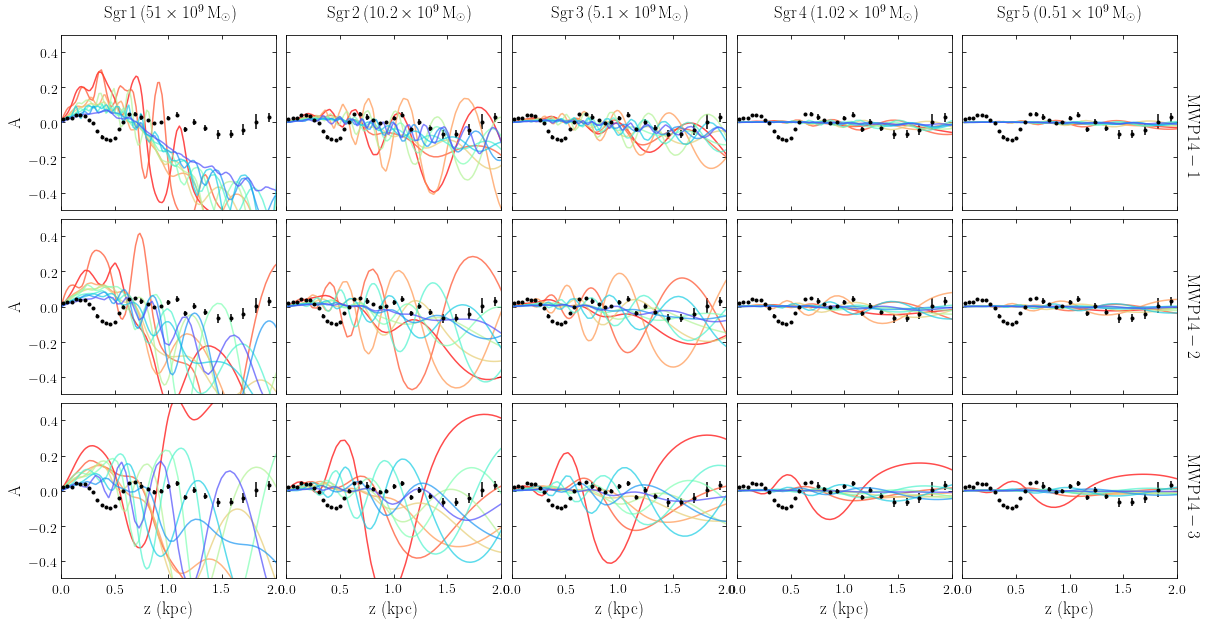

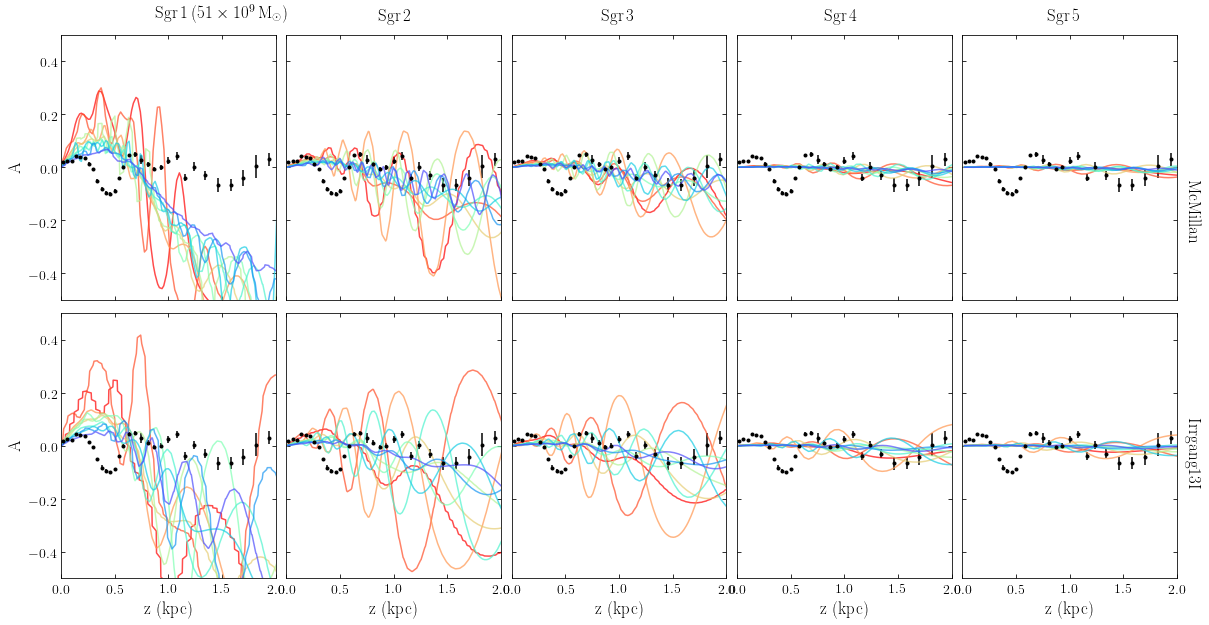

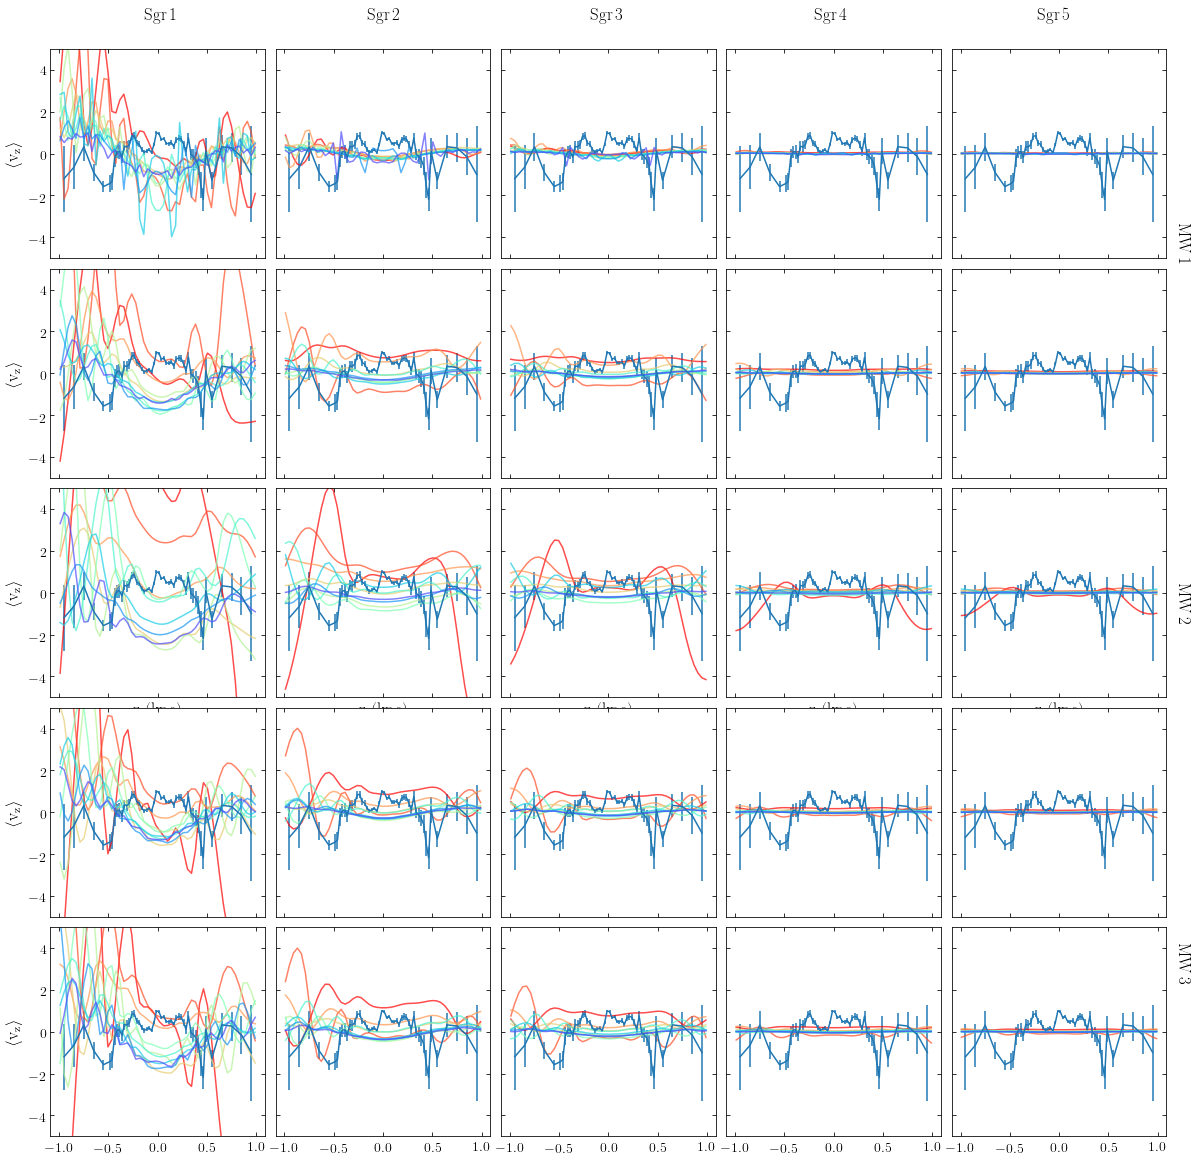

In [19]:
fig,ax= plt.subplots(3,5,figsize=(20,10),sharex=True,sharey=True)
for j in range(3):
    for k in range(5):
        ax[2,k].set_xlabel(r'$\mathrm{z\,\,(kpc)}$')
        ax[j,0].set_ylabel(r'$\mathrm{A}$')
        ax[j,k].errorbar(A_data[0],A_data[1],A_data[2],ls='',fmt='.',c='k')
        for i,aa in enumerate(A[j,k]):
            ax[j,k].plot(zA[j,k,i]*MLU[j],aa,'k',alpha=0.7,color=plt.cm.rainbow(1.-i/10.),label=str(vz_through[j,k][medianindx[j,k]][i]))
plt.xlim([0,2])
plt.ylim([-0.5,0.5])
    
plt.subplots_adjust(wspace=0.05, hspace=0.05)

plt.gcf().text(0.155, 0.9, r'$\mathrm{Sgr\,1\,(51\times10^9\,M_\odot)}$', fontsize=17)
plt.gcf().text(0.31, 0.9, r'$\mathrm{Sgr\,2\,(10.2\times10^9\,M_\odot)}$', fontsize=17)
plt.gcf().text(0.465, 0.9, r'$\mathrm{Sgr\,3\,(5.1\times10^9\,M_\odot)}$', fontsize=17)
plt.gcf().text(0.62, 0.9, r'$\mathrm{Sgr\,4\,(1.02\times10^9\,M_\odot)}$', fontsize=17)
plt.gcf().text(0.775, 0.9, r'$\mathrm{Sgr\,5\,(0.51\times10^9\,M_\odot)}$', fontsize=17)

plt.gcf().text(0.905, 0.78, r'$\mathrm{MWP14-1}$', fontsize=17,rotation=-90)
plt.gcf().text(0.905, 0.53, r'$\mathrm{MWP14-2}$', fontsize=17,rotation=-90)
plt.gcf().text(0.905, 0.28, r'$\mathrm{MWP14-3}$', fontsize=17,rotation=-90)

plt.savefig(FilePath+'plots/SgrAsym.pdf',bbox_inches='tight')


fig,ax= plt.subplots(2,5,figsize=(20,10),sharex=True,sharey=True)
for j in range(2):
    for k in range(5):
        ax[1,k].set_xlabel(r'$\mathrm{z\,\,(kpc)}$')
        ax[j,0].set_ylabel(r'$\mathrm{A}$')
        ax[j,k].errorbar(A_data[0],A_data[1],A_data[2],ls='',fmt='.',c='k')
        for i,aa in enumerate(A[j,k]):
            ax[j,k].plot(zA[j+3,k,i]*MLU[j+3],aa,'k',alpha=0.7,color=plt.cm.rainbow(1.-i/10.),label=str(vz_through[j+3,k][medianindx[j,k]][i]))
plt.xlim([0,2])
plt.ylim([-0.5,0.5])
    
plt.subplots_adjust(wspace=0.05, hspace=0.05)

plt.gcf().text(0.19, 0.9, r'$\mathrm{Sgr\,1\,(51\times10^9\,M_\odot)}$', fontsize=17)
plt.gcf().text(0.345, 0.9, r'$\mathrm{Sgr\,2}$', fontsize=17)
plt.gcf().text(0.5, 0.9, r'$\mathrm{Sgr\,3}$', fontsize=17)
plt.gcf().text(0.655, 0.9, r'$\mathrm{Sgr\,4}$', fontsize=17)
plt.gcf().text(0.81, 0.9, r'$\mathrm{Sgr\,5}$', fontsize=17)

plt.gcf().text(0.905, 0.66, r'$\mathrm{McMillan}$', fontsize=17,rotation=-90)
plt.gcf().text(0.905, 0.33, r'$\mathrm{Irrgang13I}$', fontsize=17,rotation=-90)



fig,ax= plt.subplots(5,5,figsize=(20,20),sharex=True,sharey=True)
for j in range(5):
    for k in range(5):
        ax[2,k].set_xlabel(r'$\mathrm{z\,\,(kpc)}$')
        ax[j,0].set_ylabel(r'$\mathrm{\langle v_{z}\rangle}$')
        ax[j,k].errorbar(vz_data[0],vz_data[1]-np.mean(vz_data[1]),yerr=vz_data[2])
        for i,mvz in enumerate(mV[j,k]):
            ax[j,k].plot(discs[j].z[np.abs(discs[j].z*MLU[j])<1.]*MLU[j],(mvz-np.mean(mvz))[np.abs(discs[j].z*MLU[j])<1.]*MVU[j],color=plt.cm.rainbow(1.-i/10.),alpha=0.7,label=str(i))           
plt.subplots_adjust(wspace=0.05, hspace=0.05)
ax[0,0].set_ylim([-5.,5.])

plt.gcf().text(0.19, 0.9, r'$\mathrm{Sgr\,1}$', fontsize=17)
plt.gcf().text(0.345, 0.9, r'$\mathrm{Sgr\,2}$', fontsize=17)
plt.gcf().text(0.5, 0.9, r'$\mathrm{Sgr\,3}$', fontsize=17)
plt.gcf().text(0.655, 0.9, r'$\mathrm{Sgr\,4}$', fontsize=17)
plt.gcf().text(0.81, 0.9, r'$\mathrm{Sgr\,5}$', fontsize=17)

plt.gcf().text(0.905, 0.81, r'$\mathrm{MWP14-1}$', fontsize=17,rotation=-90)
plt.gcf().text(0.905, 0.655, r'$\mathrm{MWP14-2}$', fontsize=17,rotation=-90)
plt.gcf().text(0.905, 0.5, r'$\mathrm{MWP14-3}$', fontsize=17,rotation=-90)
plt.gcf().text(0.905, 0.345, r'$\mathrm{McMillan}$', fontsize=17,rotation=-90)
plt.gcf().text(0.905, 0.19, r'$\mathrm{Irrgang13I}$', fontsize=17,rotation=-90)

# Try to match the observed asymmetry

Start by reintegrating the orbits of interest

In [20]:
aponumber=2
matchorbit= np.empty(3,dtype='object')
for i,orbit in enumerate(orbits[2,2:,0]):
            longt= np.linspace(0.,-1e4/MTU[j],1001)
            orbit.turn_physical_off()
            longo= orbit(0.)
            longo.integrate(longt,orbit._pot)
            t= longo.time()
            r= longo.r(t)

            peaks= (abs(r)>np.roll(abs(r),1))*(abs(r)>np.roll(abs(r),-1))*(t!=t[0])*(t!=t[-1])
            if len(t[peaks])>(aponumber-1):
                newt= np.linspace(0.,t[peaks][int(aponumber-1)],1001)

                matchorbit[i]= longo(0.)
                matchorbit[i].integrate(newt,orbit._pot)

### Scale the disc mass by ~35%

In [21]:
factor= np.array([[0.65,1.35],[0.65,1.35],[0.65,1.35]])

potMatch= np.empty((3,len(factor[0])),dtype='object')
discMatch= np.empty((3,len(factor[0])),dtype='object')
for j in range(3):
    for i in range(2):
        potMatch[j,i]= toVerticalPotential([bp,dp*factor[j,i],hp*2.],1.)
        discMatch[j,i]= DiscClass.StellarDisc([potMatch[j,i]],zlim=2.,vlim=120.,times=sgr2apo.t,zpt=Zpts,vpt=Vpts)
        discMatch[j,i].add_satellite(sgr_pot[2,j+2],matchorbit[j],[rho[2]*factor[j,i],sig[2]],ftype='rotate',
                                     tdep=False,method='slow',zsun='fit')

/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)

/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)

/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be ach

### Plot the nnew asymmetries to compare to the Gaia data


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  app.launch_new_instance()

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)

/usr/local/lib/python3.6/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)





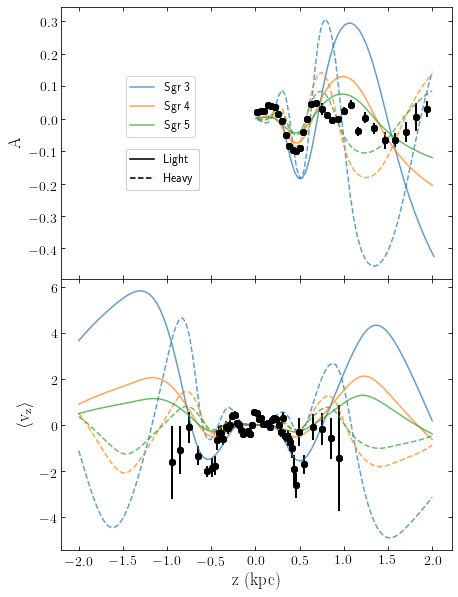

In [79]:
lines= ['-','--']
colours= ['C0','C1','C2']

fig, ax= plt.subplots(2,1, sharex=True,figsize=(7,10))
for j in range(3):
    print()
    for i,dd in enumerate(discMatch[j]):
        if i==0:
            ax[0].plot(dd.zA*MLU[2],dd.A,label='Sgr '+str(j+3),ls=lines[i],c=colours[j],alpha=0.7)
        else:
            ax[0].plot(dd.zA*MLU[2],dd.A,ls=lines[i],c=colours[j],alpha=0.7)
    ax[0].errorbar(A_data[0],A_data[1],A_data[2],c='k',ls='',fmt='o')
    ax[0].legend(bbox_to_anchor=(0.15, 0.5),loc='lower left')
    ax[0].set_ylabel(r'$\mathrm{A}$')
    
    plt.hold(True)
    l1, = plt.plot([0], '-', color='k')
    l2, = plt.plot([0], '--', color='k')

    plot_lines=[[l1, l2]]

    legend1 = plt.legend(plot_lines[0], ["Light", "Heavy"], bbox_to_anchor=(0.15, 1.5), loc='upper left')
    plt.gca().add_artist(legend1) 
    
for j in range(3):
    for i,dd in enumerate(discMatch[j]):
        if i==0:
            ax[1].plot(dd.z*MLU[2],(dd.meanV-dd.meanV[50])*MVU[2],label='Sgr '+str(j+3),ls=lines[i],c=colours[j],alpha=0.7)
        else:
            ax[1].plot(dd.z*MLU[2],(dd.meanV-dd.meanV[50])*MVU[2],ls=lines[i],c=colours[j],alpha=0.7)

    ax[1].errorbar(vz_data[0],vz_data[1],vz_data[2],c='k',ls='',fmt='o')
    ax[1].set_xlabel(r'$\mathrm{z\,\,(kpc)}$')
    ax[1].set_ylabel(r'$\mathrm{\langle v_z\rangle}$')   
    
plt.subplots_adjust(wspace=0., hspace=0.)

plt.savefig(FilePath+'plots/matchA.pdf',bbox_inches='tight')